In [2]:
import matplotlib.pyplot as plt

import healpy as hp
import numpy as np

%load_ext autoreload
%autoreload 2

%config InlineBackend.figure_format = 'retina'

plt.rcParams['font.size']=13
plt.rcParams['font.family']='stix'
plt.rcParams['text.usetex']=True
plt.rcParams['figure.figsize']= (6.5,4)
plt.rcParams['figure.dpi']=150


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Import the cosmoboost package: 

In [3]:
import cosmoboost as cb

# Initialize the Doppler and Aberration Kernel

In order to initialize the kernel, you need to set up the parameters dictionary. The default values are stored in `cosmoboost.DEFAULT_PARS`. 

In [4]:
#read the default parameters from cosmoboost
pars = cb.DEFAULT_PARS

Let's see what it contains

In [5]:
pars

{'d': 1,
 's': 0,
 'beta': 0.00123,
 'lmin': 0,
 'lmax': 1000,
 'delta_ell': 6,
 'T_0': 2.72548,
 'beta_expansion_order': 4,
 'derivative_dnu': 1.0,
 'normalize': True,
 'frequency_function': 'CMB'}

## quick note on the parameters

**The important ones**

`d`: Doppler weight of the observable

`s`: Spin weight of the observable (0 for temperature and 2 for polarization)

`beta`: Velocity of the frame [assumes motion in the $\hat{z}$ direction (north galactic pole)]

`lmax`: Limits the kernel calculation up to this ell mode 

`delta_ell`: Limits the kernel calculation to this many neighbors on each side of every ell mode. For example, `delta_ell=2` calculates the motion induced leakage from `ell-2`, `ell-1`, `ell+1`, and `ell+2`. By default the code uses the recommended number of modes. 

`T_0`: Average temperature of the background radiation in units of Kelvin.

**The rest**

`lmin`: Should always be set to zero. This is only defined for the sake of clarity and to specifiy that ell does NOT start from 2. 

`beta_expansion_order`: Calculates the generalized Doppler and aberration effect up to this order. 

`normalize`: If set to True, calculates everything in units of temperature. 

`derivative_dnu`: Frequency resolution used for derivatives in the generalized Doppler and aberration kernel. 

`frequency_function`: Determines the frequency function of the background radiation. Currently can be only set to `"CMB"` and `"tSZ"`.

# Instantiating the Kernel 

Now let's change some of the parameters

In [6]:
lmax=pars['lmax']=1500
delta_ell = pars['delta_ell']=8
pars['d']=1


beta=pars['beta']
T_0 = pars["T_0"]

Now let's initialize the kernel using these parameters m

In [7]:
# initialize the kernel 
kernel = cb.Kernel(pars)

Calculating the index matrices...


initializing fits file for the matrices...

Matrices saved in file:
/Users/siavashyasini/Dropbox/Cosmology/Projects/2019/CosmoBoost/cosmoboost/kernel/beta_0.00123/lmax_1500/M_T_s_0_delta_8_lmax_1500_beta_0.00123.fits

Done!

Solving kernel ODE for d=1
calculating the Doppler and aberration Kernel elements started at 12:37:24 PM

beta (v/c) :  0.00123
eta (arctanh(beta)) :  0.001230000620289563


/Users/siavashyasini/anaconda/envs/py36/lib/python3.6/site-packages/scipy/integrate/odepack.py:250: ODEintWarning: Integration successful.
  warnings.warn(warning_msg, ODEintWarning)



calculating the Doppler and aberration Kernel elements was done in 0.6 min.

dirname = /Users/siavashyasini/Dropbox/Cosmology/Projects/2019/CosmoBoost/cosmoboost/kernel/beta_0.00123/lmax_1500

initializing fits file for the kernel...

Kernel saved in:
/Users/siavashyasini/Dropbox/Cosmology/Projects/2019/CosmoBoost/cosmoboost/kernel/beta_0.00123/lmax_1500/K_T_s_0_delta_8_lmax_1500_beta_0.00123.fits


The elements of `kernel.mLl` are organized in a matrix such that each row corresponds to a ($m,\ell'$) pair, and each column to a $\Delta \ell$ value. The Each block starts with an $m$ and goes down through all possible values of $\ell'$ (0 to $m$). Here's an example of the matrix around the neighbor of $(m,\ell')=(0,501)$:

|          -        |  -  |      -     | $\Delta \ell$ |      -     |  -  |
|:-----------------:|:---:|:----------:|---------------|:----------:|:---:|
|         -         | ... | -1         | 0             | +1         | ... |
|         -         | ... | (0,500, 409)  | (0,500, 500)    | (0,500, 501) | ... |
| ($m,\ell', \ell$) | ... | (0,501, 500) | (0,501, 501)    | (0,501, 502) | ... |
|         -         | ... | (0,502, 501) | (0,502, 502)    | (0,502, 503) | ... |

Now let's slice and print the K_{m, ell', ell} matrix for these values of $m$ and $\ell'$ which we call `(m,L)`

In [8]:
m=0
L = 501 

# and let's also calculate the generalized kernel at this frequency 
nu_0 = 217 #GHz 

In [9]:
# this function let's us slice the (m,L) row
indx = cb.mL2indx(m,L,lmax)

In [10]:
# frequency-independent
K_mL_slice = kernel.mLl[indx]

# frequency-dependent (evaluated at 217 GHz)
K_nu_mL_slice = kernel.nu_mLl(nu_0)[indx]

print("K_mLl = {}\n".format(K_mL_slice))
print("K_mLl_nu({}GHz) = {}".format(nu_0, K_nu_mL_slice))

Kernel elements are normalized

K_mLl = [ 1.89433823e-09  4.96710787e-08  1.13828693e-06  2.23288034e-05
  3.64093758e-04  4.73251214e-03  4.58942698e-02  2.93719430e-01
  9.07113680e-01 -2.94248970e-01  4.62499978e-02 -4.81683239e-03
  3.75782833e-04 -2.34626821e-05  1.22260458e-06 -5.47510888e-08
  2.15383883e-09]

K_mLl_nu(217GHz) = [ 1.89681202e-09  4.96516874e-08  1.13795317e-06  2.23240923e-05
  3.64042017e-04  4.73210194e-03  4.58922197e-02  2.93714697e-01
  9.07112482e-01 -2.94253326e-01  4.62507965e-02 -4.81686358e-03
  3.75776267e-04 -2.34614031e-05  1.22247677e-06 -5.47420447e-08
  2.14931734e-09]


/Users/siavashyasini/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['stix'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


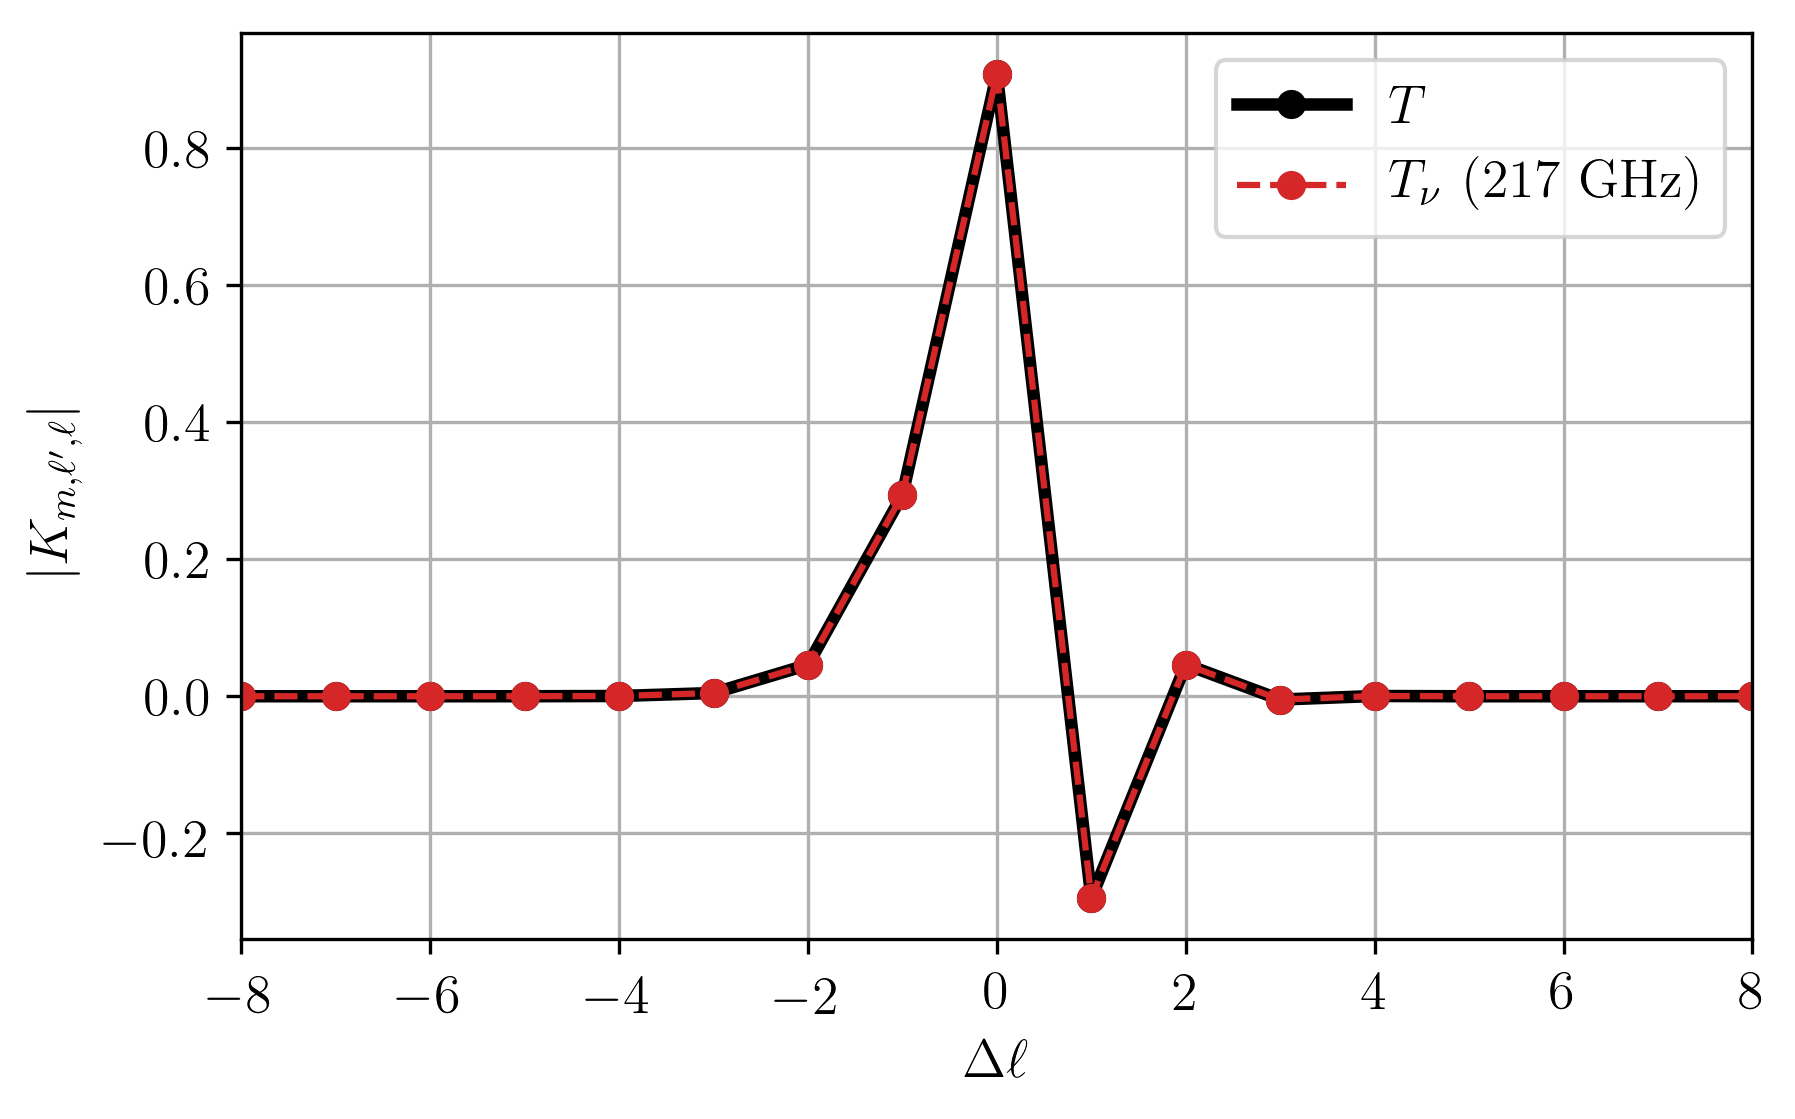

In [11]:

# and here's the plot
dell = np.arange(-kernel.delta_ell,kernel.delta_ell+1)

plt.plot(dell,(K_mL_slice),color="k",marker="o",lw=3, label='$T$')
plt.plot(dell,(K_nu_mL_slice),color="tab:red",ls="--",marker="o",label="$T_\\nu$ ({0} GHz)".format(nu_0))
plt.xlabel(r"$\Delta \ell$")
plt.ylabel(r"$|K_{m,\ell',\ell}|$")

plt.xlim(-delta_ell,delta_ell)
plt.grid()
plt.legend()
plt.show()

The difference between the Kernel coefficients for thermodynmic temperature and brightness temperature are negligible in this range at 217 GHz.

# Simulate the sky

In [12]:
import healpy as hp 
import numpy as np

T_0 = 2.725
ell=np.arange(lmax+1)

# here's a sample power spectrum generated with CAMB
Cl_camb = np.load("sample_Cl.npz")

Cl_TT = Cl_camb["TT"][:lmax+1]
Cl_EE = Cl_camb["EE"][:lmax+1]
Cl_BB = Cl_camb["BB"][:lmax+1]
Cl_TE = Cl_camb["TE"][:lmax+1]

# let's use it to simulate a CMB map
Cl = np.array([Cl_TT,Cl_EE,Cl_BB,Cl_TE])
alm_T, alm_E, alm_B = hp.synalm(Cl,lmax=lmax,new=True,verbose=True)

# this is our alm in the rest frame
alm_r = np.array([alm_T, alm_E, alm_B])

# this is the power spectrum of the simulation
Cl_r = hp.alm2cl(alm_r)

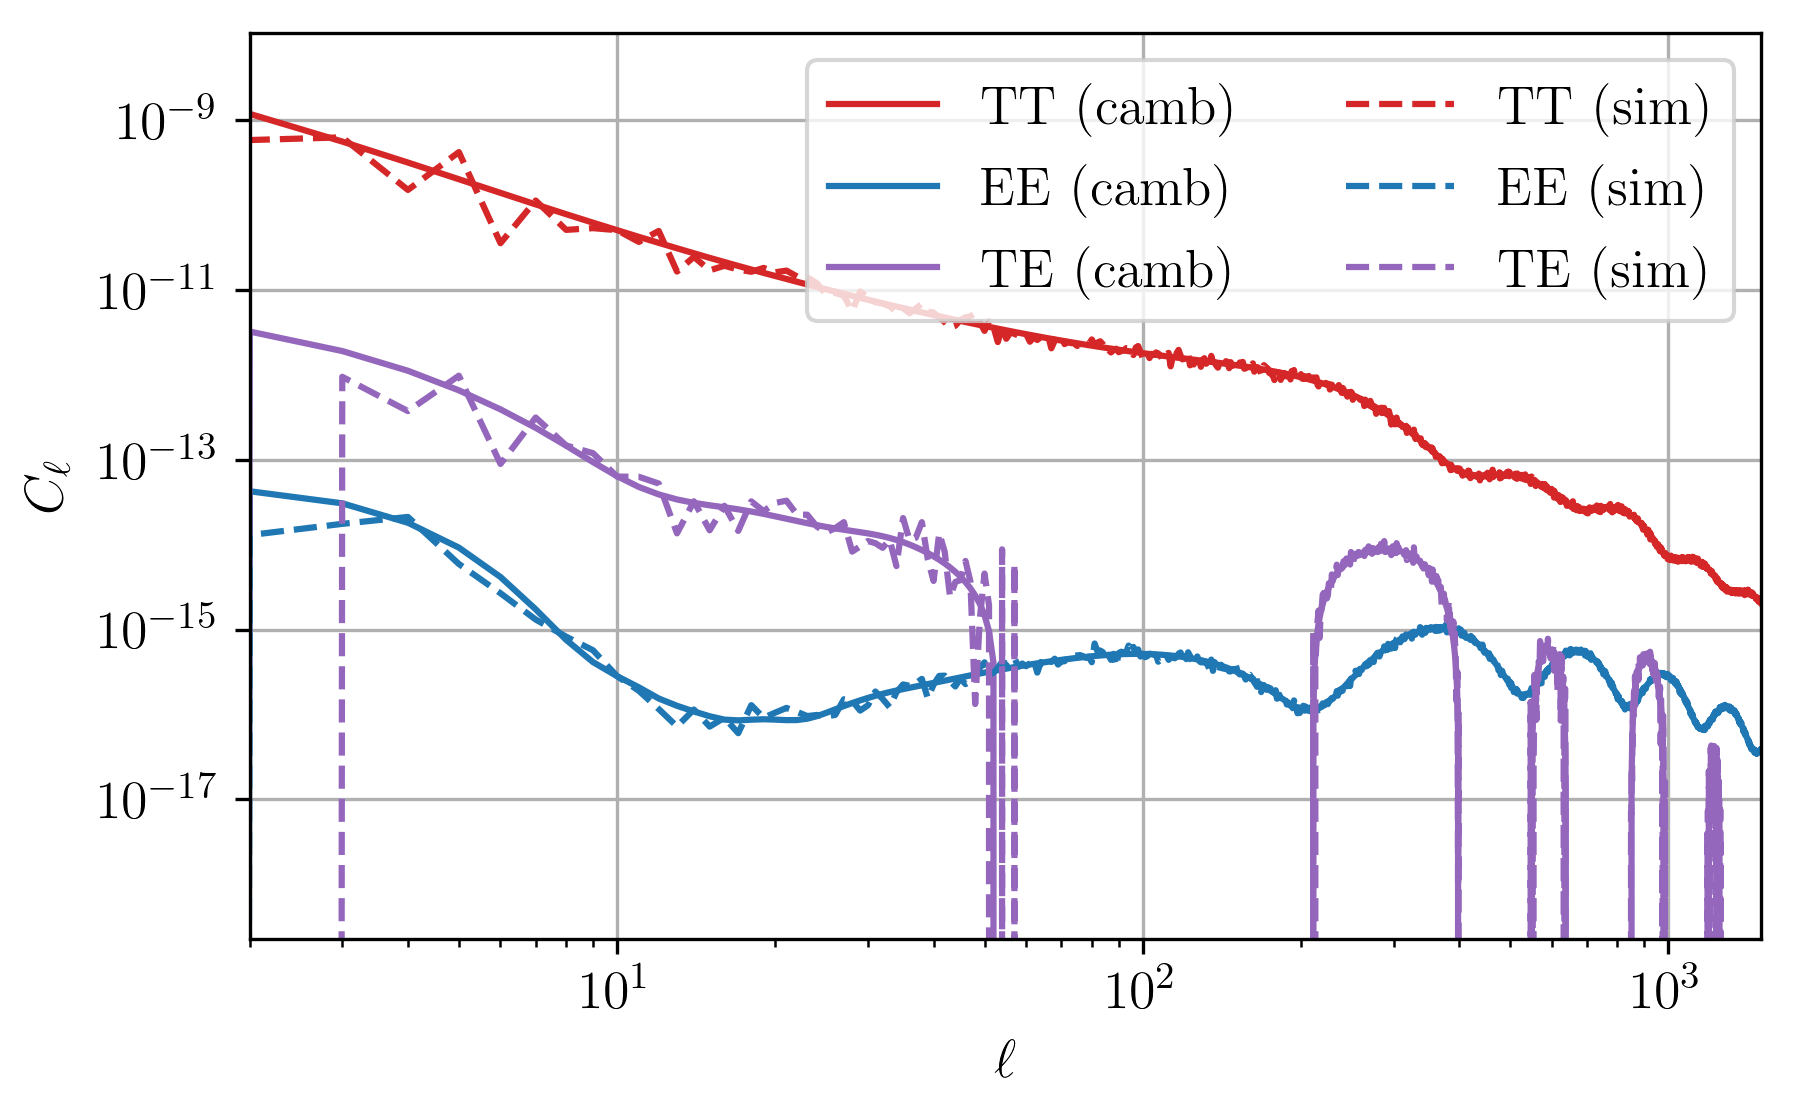

In [13]:
# here's a plot the power spectra in the rest frame

plt.plot(ell,Cl_TT, label="TT (camb)",color='tab:red')
plt.plot(ell,Cl_EE, label="EE (camb)",color='tab:blue')
plt.plot(ell,Cl_TE, label="TE (camb)",color='tab:purple')

plt.plot(ell,Cl_r[0],label="TT (sim)",color='tab:red',linestyle='--')
plt.plot(ell,Cl_r[1],label="EE (sim)",color='tab:blue',linestyle='--')
plt.plot(ell,Cl_r[3],label="TE (sim)",color='tab:purple',linestyle='--')

plt.xlabel("$\ell$")
plt.ylabel("$C_\ell$")

plt.xscale("log")
plt.yscale("log")

plt.grid()
plt.legend(loc="upper right",ncol=2)
plt.xlim(2,lmax)
plt.show()

# Boost the Whole Sky

## temperature only

Boosting the alms using `CosmoBoost` is very simple

In [14]:
alm_T_r = alm_T

# boost the temperature alm 
alm_T_b = cb.boost_alm(alm_T_r,kernel)

INFO:cosmoboost.cosmoboost:boosting T_lm


adding new axis to the input alm...

boosting T
Done!


## other options

You can also pass `alm_r` to the `cb.boost_alm` function which will boost both temperature and polarization:

`alm_b = cb.boost_alm(alm_r,kernel)`

And in order to boost a frequency-dependent observable, you can pass the frequency as the last argument as such

`alm_b_217 = cb.boost_alm(alm_r, kernel, 217)`

## boosted power spectreum

In [15]:
from cosmoboost.lib import jeong
from scipy.ndimage import gaussian_filter as GF

In [16]:
# calculate the temperature power spectrum in the rest and boosted frame
Cl_TT_r = Cl_r[0] 
Cl_TT_b = hp.alm2cl(alm_T_b)

`CosmoBoost` also provides an additional boosting method `cb.boost_Cl` which can be directly applied to the power spectrum. However, since this method assumes azimuthal symmetry, it underestimates the effect.

In [17]:
Cl_TT_b_approx = cb.boost_Cl(Cl_TT_r,kernel)

Now let's plot the power spectra together

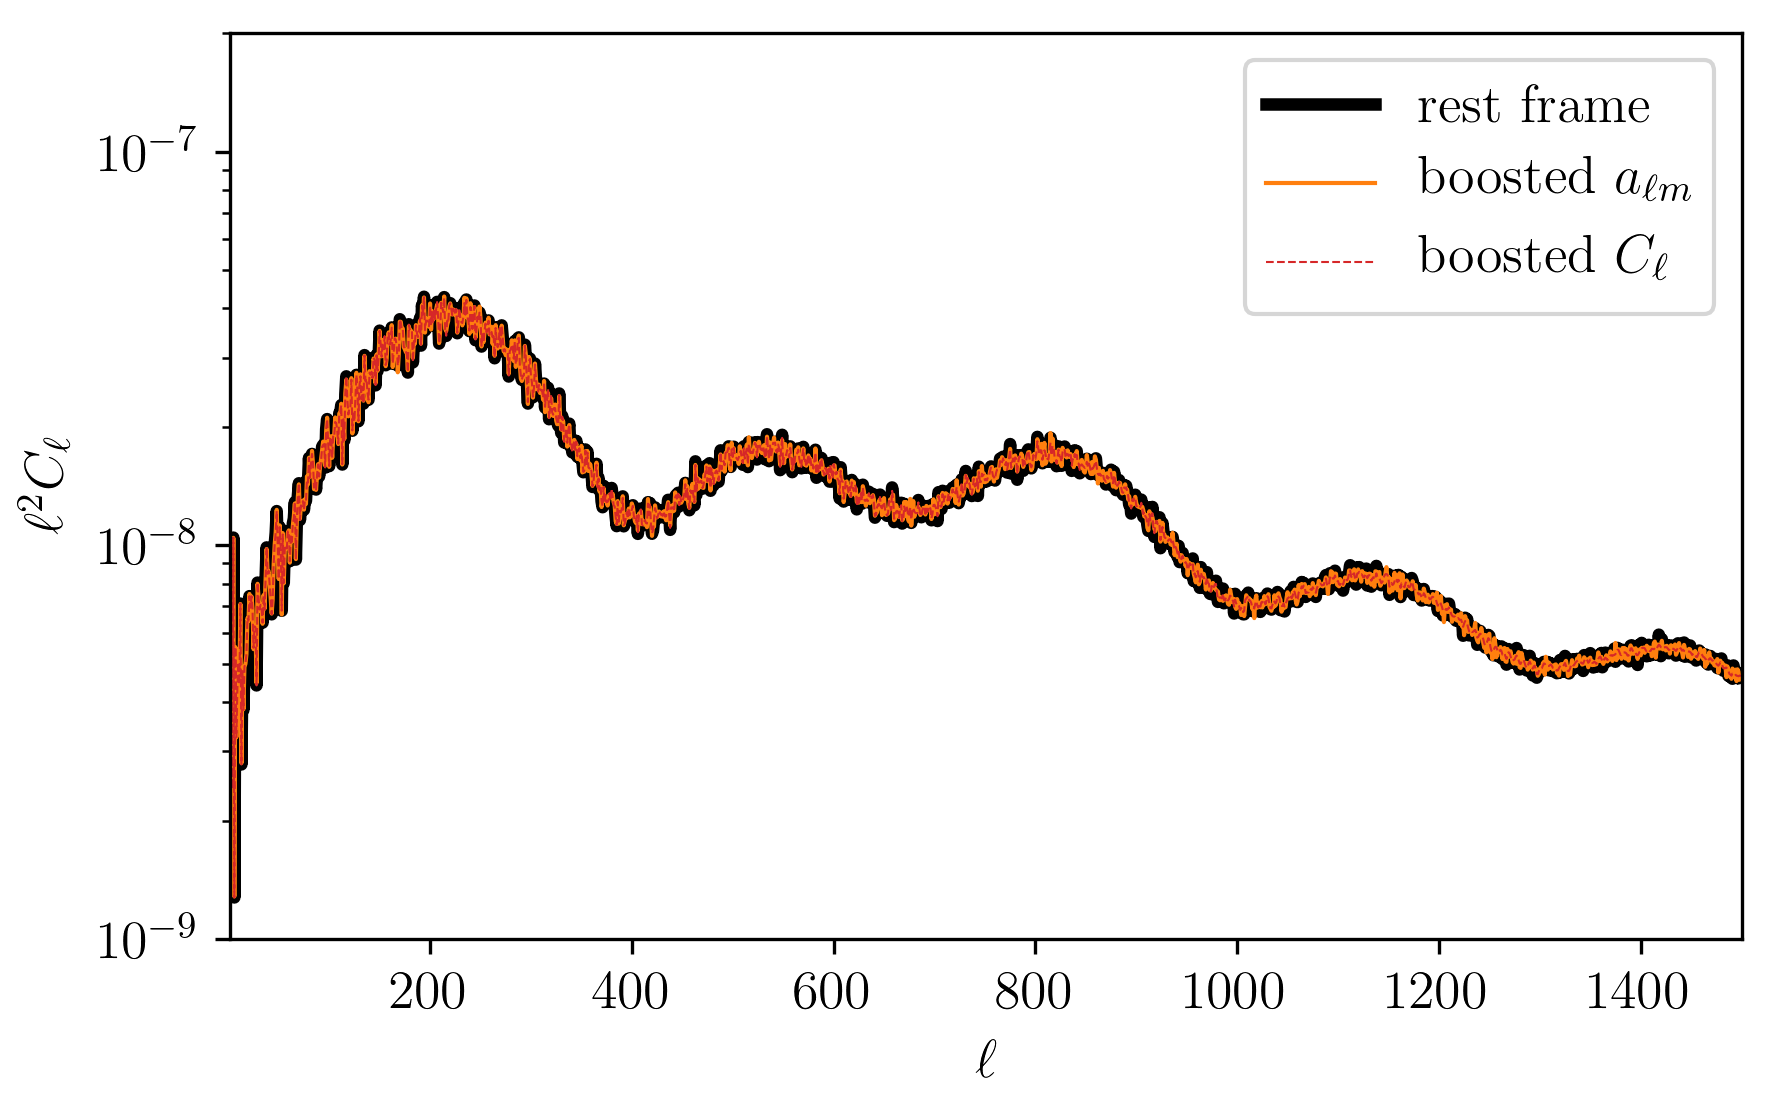

In [18]:
plt.plot(ell,ell**2*Cl_TT_r,linewidth=3,color='k',label='rest frame')
plt.plot(ell,ell**2*Cl_TT_b,linewidth=1,color="tab:orange",label='boosted $a_{\ell m}$')
plt.plot(ell,ell**2*Cl_TT_b_approx,linewidth=0.5,ls='--',color="tab:red",label='boosted $C_{\ell}$')


plt.xlabel("$\ell$")
plt.ylabel("$\ell^2 C_\ell$")

plt.yscale("log")
plt.xlim(2,lmax)
plt.ylim(1E-9,2E-7)
plt.legend()

plt.show()

In order to see the difference between them better, we calculate the relative change between the boosted and the rest frame spectra.

In [19]:
# calculate the relative change of the boosted Cl using the accurate formalism
dCl_TT_b = (Cl_TT_b - Cl_TT_r)
dCl_Cl_TT_b = dCl_TT_b/Cl_TT_r

# and for the approximation
dCl_TT_b_approx = (Cl_TT_b_approx - Cl_TT_r)
dCl_Cl_TT_b_approx = dCl_TT_b_approx/Cl_TT_r


# Gaussian smooth the results with a window
dL = 20

dCl_Cl_TT_b_GF = GF(dCl_Cl_TT_b, dL, mode="constant")
dCl_Cl_TT_b_approx_GF = GF(dCl_Cl_TT_b_approx, dL, mode="constant")


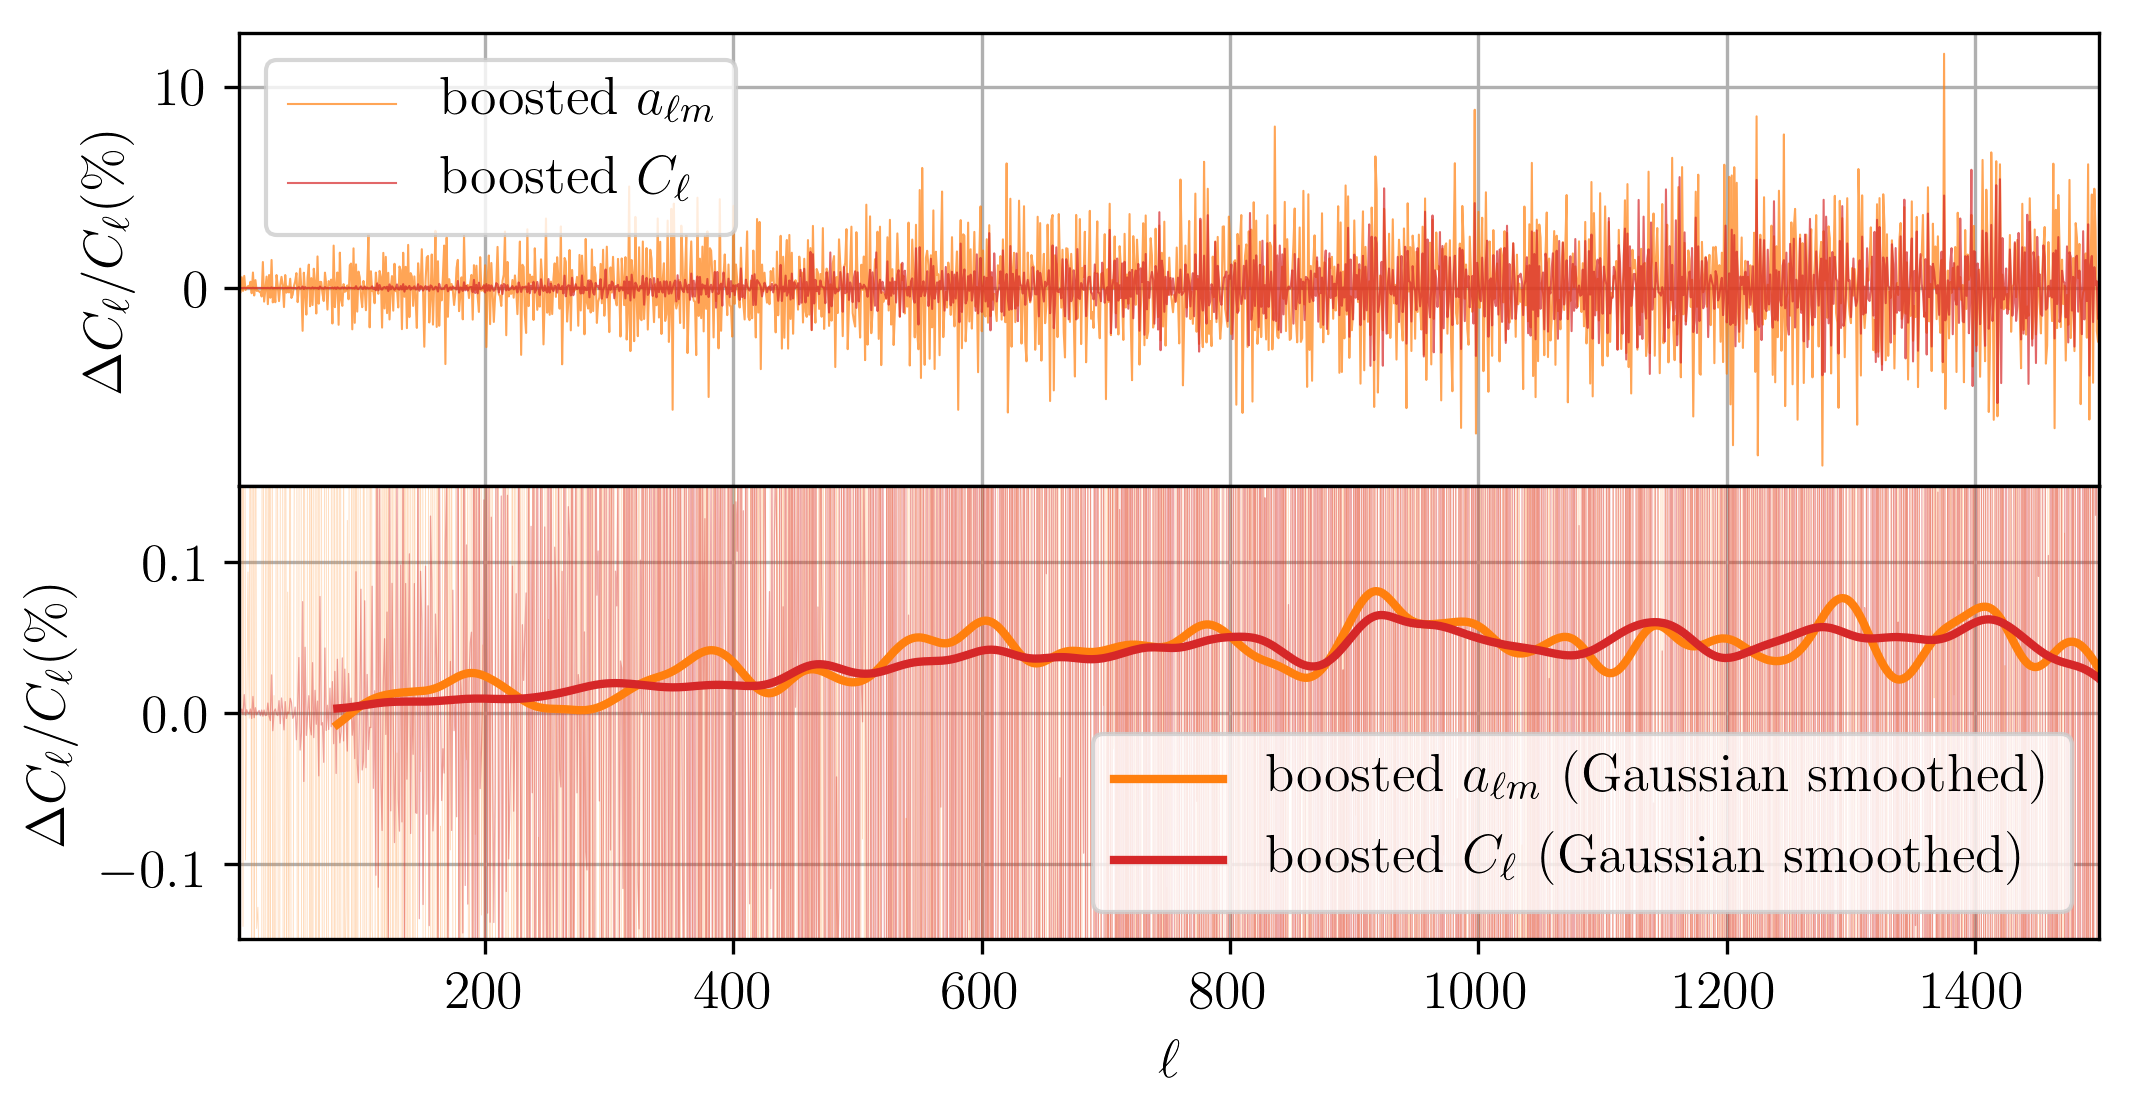

In [20]:
fig, ax = plt.subplots(2,1,figsize=(8,4),sharex=True)
fig.subplots_adjust(hspace=0)

ax[0].plot(100*dCl_Cl_TT_b,linewidth=0.5,alpha=0.7,color="tab:orange",label='boosted $a_{\ell m}$')
ax[0].plot(100*dCl_Cl_TT_b_approx,linewidth=0.5, alpha=0.7,color="tab:red",label='boosted $C_\ell$')


ax[1].plot(100*dCl_Cl_TT_b,linewidth=0.2,alpha=0.3,color="tab:orange")
ax[1].plot(100*dCl_Cl_TT_b_approx,linewidth=0.3, alpha=0.4,color="tab:red")
ax[1].plot(100*dCl_Cl_TT_b_GF,linewidth=2,color="tab:orange",label='boosted $a_{\ell m}$ (Gaussian smoothed)')
ax[1].plot(100*dCl_Cl_TT_b_approx_GF,linewidth=2,color="tab:red",label='boosted $C_\ell$ (Gaussian smoothed)')

ax[1].set_ylim(-0.15,0.15)

for axis in ax:
    axis.set_xlabel("$\ell$")
    axis.set_ylabel("$\Delta C_\ell/C_\ell (\%)$")
    axis.set_xlim(2,lmax)
    axis.grid()
    axis.legend()


plt.show()

The effect of the boost is negligible for in whole-sky maps. However, this is not the case for partial sky observations as we will see in the next section. 

# Boost a Masked Sky

In [21]:
def mask_cutbelowlat(cut_angle, lat_pix):
    """mask all the pixels beloe the latitude cut_angle [deg]"""
    mask = np.ones_like(lat_pix)
    mask[(lat_pix < cut_angle)] = 0.
    
    #approximate f_sky using the number of pixels
    f_sky = len(mask[mask == 1.]) / len(mask)

    return mask, f_sky

In [22]:
NSIDE=512
NPIX = hp.nside2npix(NSIDE)
lon_pix, lat_pix = hp.pix2ang(NSIDE,np.arange(NPIX),lonlat=True)

In [23]:
mask_60,f_sky = mask_cutbelowlat(60,lat_pix)

In [24]:
T_map_r = hp.alm2map(alm_T_r,NSIDE)
T_map_b = hp.alm2map(alm_T_b,NSIDE)

T_map_r_ma = mask_60*T_map_r
T_map_b_ma = mask_60*T_map_b


Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


/Users/siavashyasini/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['stix'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


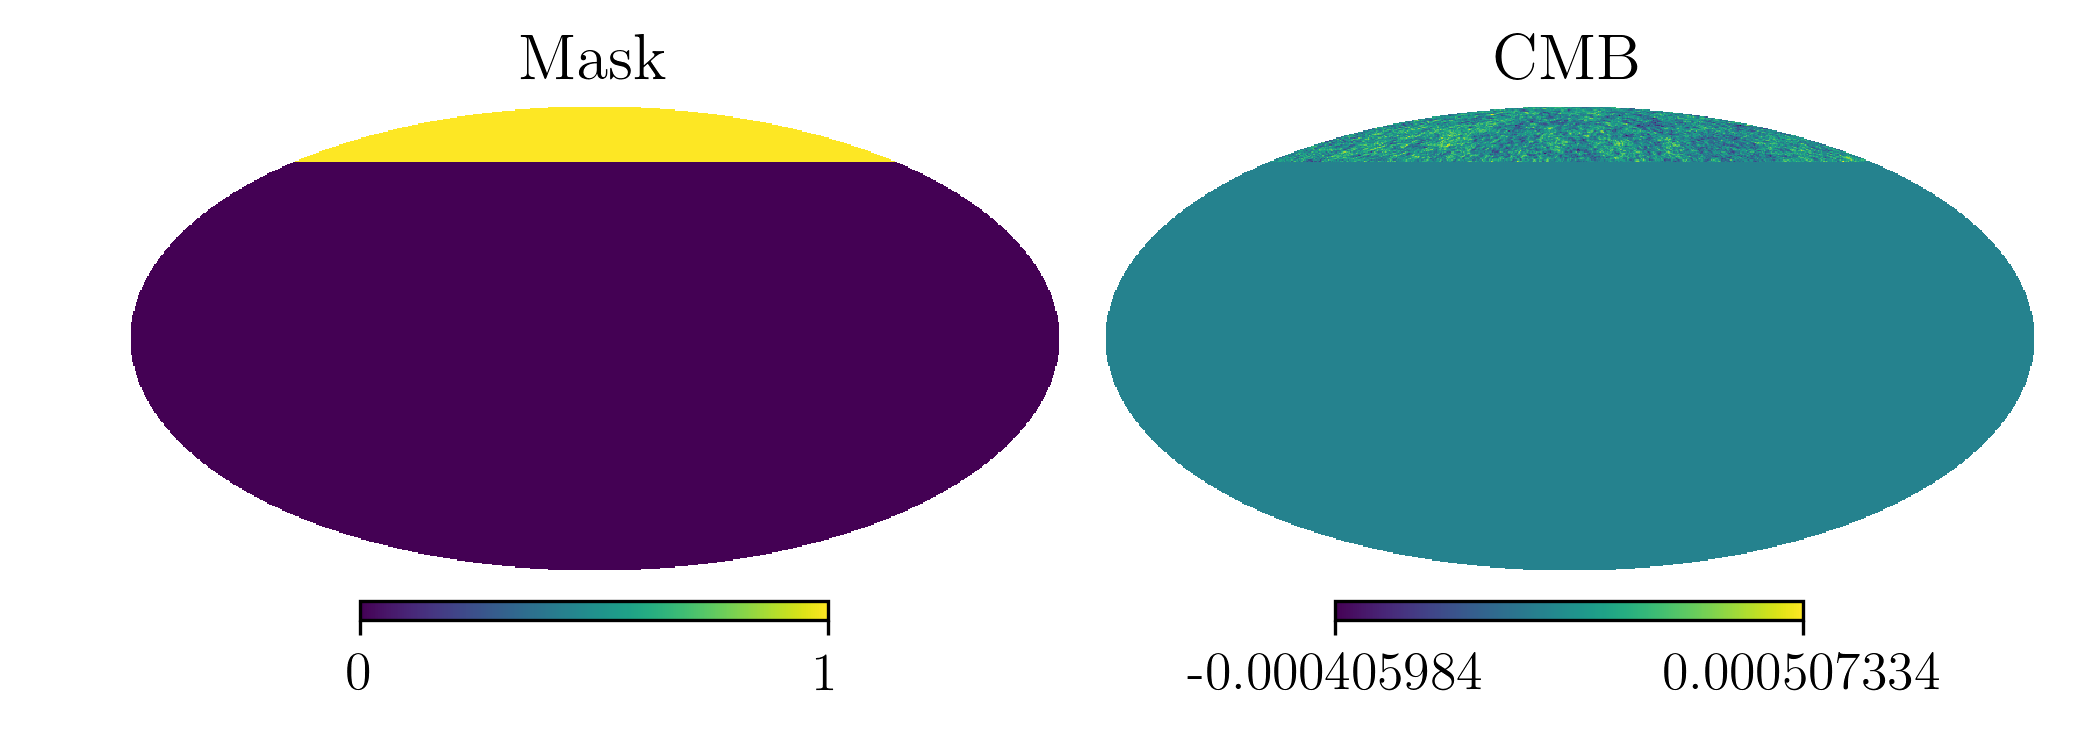

In [25]:
hp.mollview(mask_60, sub=221,title="Mask")
hp.mollview(T_map_r_ma, sub=222,title="CMB")


In [26]:
Cl_TT_r_ma =(1/f_sky)*hp.anafast(T_map_r_ma,lmax=lmax)

Cl_TT_b_ma =(1/f_sky)*hp.anafast(T_map_b_ma,lmax=lmax)


In [27]:
# calculate the relative change of the boosted Cl using the accurate formalism
dCl_TT_b_ma = (Cl_TT_b_ma - Cl_TT_r_ma)
dCl_Cl_TT_b_ma = dCl_TT_b_ma/Cl_TT_r_ma

# Gaussian smooth the results with a window
dL = 20

dCl_Cl_TT_b_ma_GF = GF(dCl_Cl_TT_b_ma, dL, mode="constant")


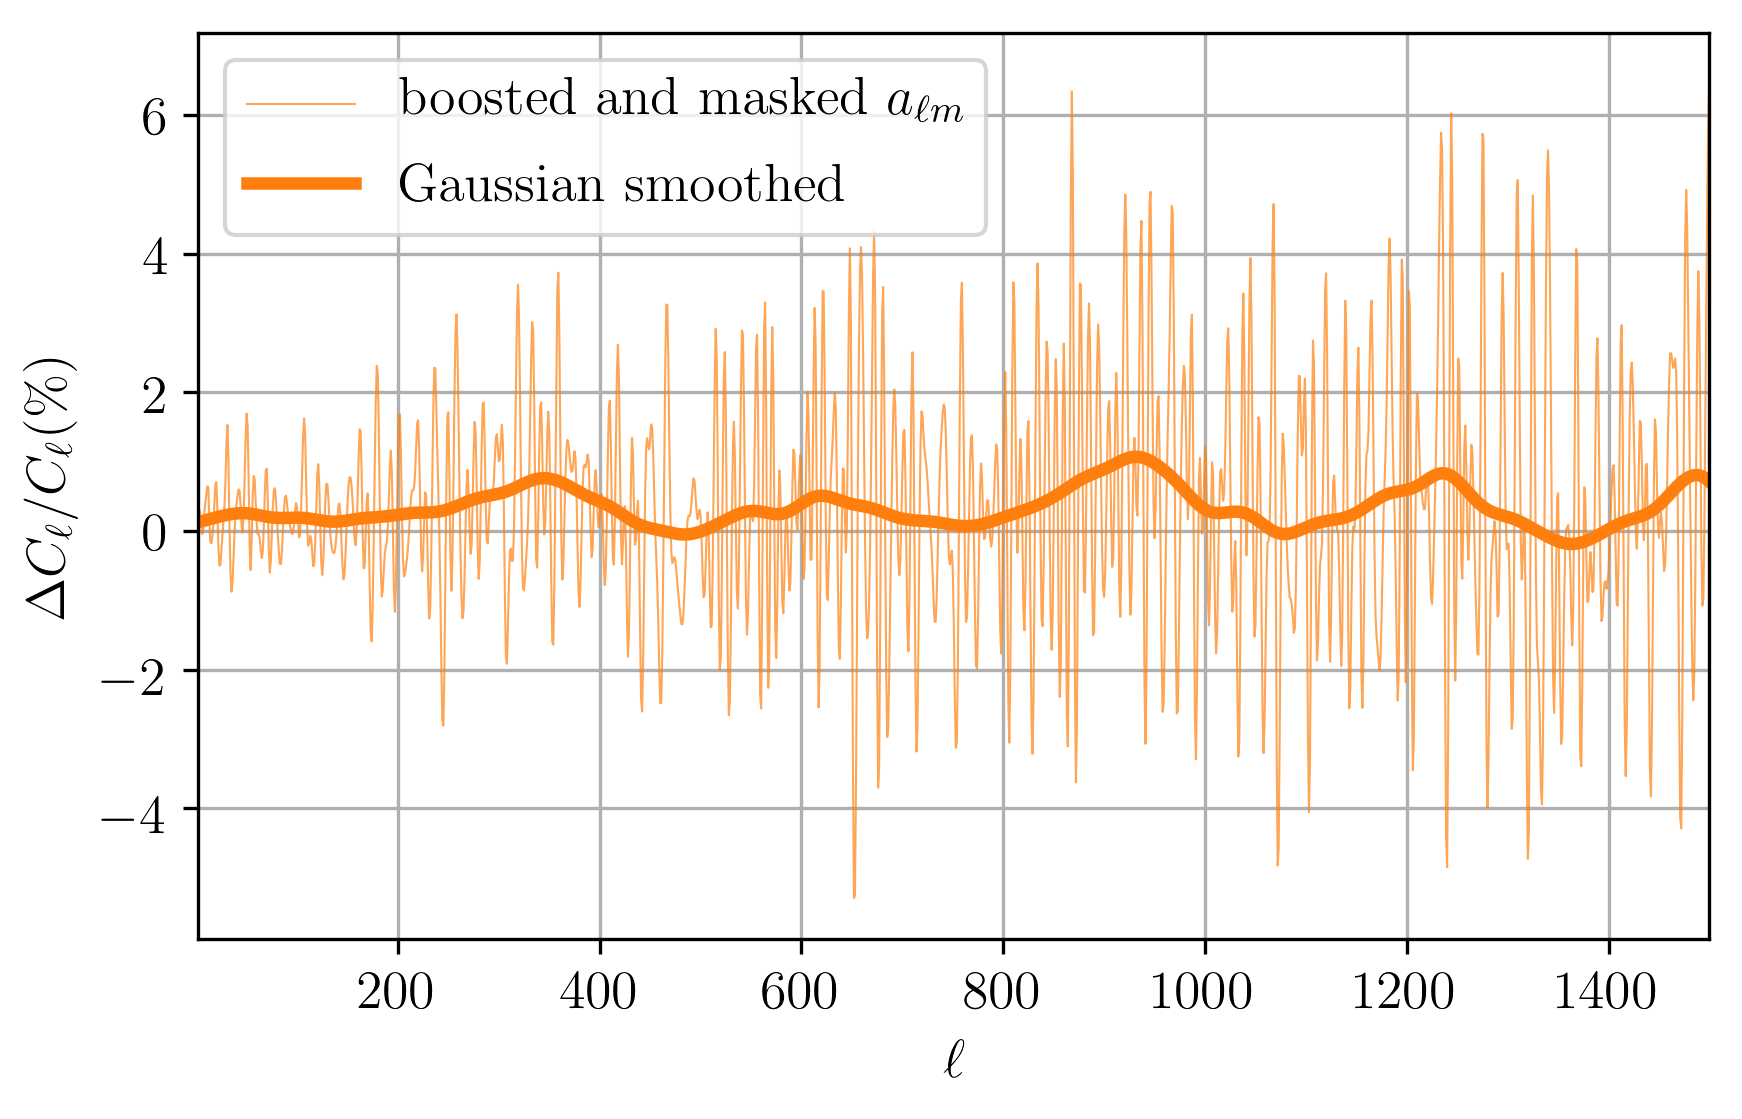

In [28]:
plt.plot(ell,100*(dCl_Cl_TT_b_ma),linewidth=0.5,alpha=0.7,color="tab:orange",label="boosted and masked $a_{\ell m}$")
plt.plot(ell,100*(dCl_Cl_TT_b_ma_GF),linewidth=3,color="tab:orange",label="Gaussian smoothed")

plt.xlabel("$\ell$")
plt.ylabel("$\Delta C_\ell/C_\ell (\%)$")

plt.grid()
plt.legend()
plt.xlim(2,lmax)
plt.show()

We see that the effect of the boost on masked portions of the sky is not negligible and can exceed a few percent. 